In [1]:
import pandas as pd
import cv2
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn import cross_validation
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import biosppy

/home/sabu/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/home/sabu/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [16]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder

In [2]:
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Activation, Flatten, MaxPooling2D, Dropout
from keras.layers.advanced_activations import LeakyReLU

Using TensorFlow backend.


In [3]:
data = pd.read_csv('arrhythmia.csv',header=None,na_values=['?'])
data.shape

(452, 280)

In [4]:
def num_missing(x):
    return sum(x.isnull())

#Applying per column:
print("\nMissing values per column:")
print(data.apply(num_missing, axis=0))


Missing values per column:
0        0
1        0
2        0
3        0
4        0
5        0
6        0
7        0
8        0
9        0
10       8
11      22
12       1
13     376
14       1
15       0
16       0
17       0
18       0
19       0
20       0
21       0
22       0
23       0
24       0
25       0
26       0
27       0
28       0
29       0
      ... 
250      0
251      0
252      0
253      0
254      0
255      0
256      0
257      0
258      0
259      0
260      0
261      0
262      0
263      0
264      0
265      0
266      0
267      0
268      0
269      0
270      0
271      0
272      0
273      0
274      0
275      0
276      0
277      0
278      0
279      0
Length: 280, dtype: int64


In [5]:
data.dropna(axis=1,how ='any',inplace = True)

In [6]:
data.shape

(452, 275)

In [7]:
cols = list(data)
nunique = data.apply(pd.Series.nunique)
cols_to_drop = nunique[nunique == 1].index
data.drop(cols_to_drop, axis=1,inplace = True)

In [8]:
data.shape

(452, 258)

In [9]:
X = data.iloc[:,0:256]
Y = data.iloc[:,257]

In [10]:
Y1=list(Y)
Y1=np.array(Y1)
Y1=Y1.astype(np.int)

In [11]:
Y1.shape

(452,)

In [12]:
X1=X.values
Y1=Y.values

In [13]:
pca = PCA(n_components=255)
pca.fit(X)
x_features = pca.transform(X)

In [14]:
x_features.shape

(452, 255)

In [17]:
X_train, X_test, Y_train, Y_test= train_test_split(x_features,Y1,test_size=0.05, random_state=0)
X_test.shape

(23, 255)

In [19]:
Y_train = Y_train.reshape(-1,1)

In [20]:
sc=StandardScaler()
X_train=sc.fit_transform(X_train)
X_test=sc.fit_transform(X_test)

onehotencoder=OneHotEncoder(categorical_features=[0])
Y_train=onehotencoder.fit_transform(Y_train).toarray()

In [44]:
data = X_train[0]
signals = []
count = 1
peaks =  biosppy.signals.ecg.christov_segmenter(signal=data, sampling_rate = 200)[0]
for i in (peaks[1:-1]):
    diff1 = abs(peaks[count - 1] - i)
    diff2 = abs(peaks[count + 1]- i)
    x = peaks[count - 1] + diff1//2
    y = peaks[count + 1] - diff2//2
    signal = data[x:y]
    signals.append(signal)
    count += 1

/home/sabu/anaconda3/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/sabu/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/home/sabu/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted

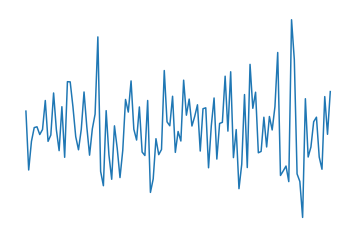

In [45]:
array = signals
directory = "data"
for count, i in enumerate(array):
  fig = plt.figure(frameon=False)
  plt.plot(i) 
  plt.xticks([]), plt.yticks([])
  for spine in plt.gca().spines.values():
     spine.set_visible(False)

  filename = directory + '/' + str(count)+'.png'
  fig.savefig(filename)
  im_gray = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
  im_gray = cv2.resize(im_gray, (128, 128), interpolation = cv2.INTER_LANCZOS4)
  cv2.imwrite(filename, im_gray)

In [46]:
Y_train = Y_train.reshape(-1,1)

In [23]:
X_train = X_train.reshape(-1,15,15,1)

ValueError: cannot reshape array of size 109395 into shape (15,15,1)

In [22]:
X_train.shape

(429, 255)

In [24]:
model = Sequential()
model.add(Conv2D(64,(2,2),input_shape = (15,15,1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
model.add(Conv2D(64,(2,2)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
model.add(Conv2D(64,(2,2)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))   
model.add(Flatten())
model.add(Dense(13))
model.add(Activation('softmax'))
model.compile(loss="categorical_crossentropy",optimizer="adam",metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        320       
_________________________________________________________________
activation (Activation)      (None, 14, 14, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 7, 7, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 6, 6, 64)          16448     
_________________________________________________________________
activation_1 (Activation)    (None, 6, 6, 64)          0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 64)          0         
__________

In [25]:
model.fit(X_train,Y_train,epochs=500,validation_split=0.1)

ValueError: Error when checking input: expected conv2d_input to have 4 dimensions, but got array with shape (429, 255)

In [74]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
import tensorflow as tf

#initialising the ann
model = tf.keras.models.Sequential() #for the feed-forward network
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(128,activation = tf.nn.relu))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(128,activation = tf.nn.relu))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(64,activation = tf.nn.relu))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(64,activation = tf.nn.relu))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(13,activation= tf.nn.softmax))
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.fit(X_train,Y_train,epochs=100,validation_split=0.1)

Train on 386 samples, validate on 43 samples
Epoch 1/100
386/386 [==============================] - 1s 2ms/step - loss: 2.1668 - acc: 0.4145 - val_loss: 1.9815 - val_acc: 0.5581
Epoch 2/100
386/386 [==============================] - 0s 116us/step - loss: 1.6874 - acc: 0.5492 - val_loss: 1.9316 - val_acc: 0.5581
Epoch 3/100
386/386 [==============================] - 0s 124us/step - loss: 1.3973 - acc: 0.5777 - val_loss: 1.9148 - val_acc: 0.5581
Epoch 4/100
386/386 [==============================] - 0s 126us/step - loss: 1.1778 - acc: 0.6062 - val_loss: 1.8286 - val_acc: 0.5814
Epoch 5/100
386/386 [==============================] - 0s 127us/step - loss: 0.9383 - acc: 0.6606 - val_loss: 1.8442 - val_acc: 0.5349
Epoch 6/100
386/386 [==============================] - 0s 122us/step - loss: 0.7243 - acc: 0.7306 - val_loss: 1.8763 - val_acc: 0.5581
Epoch 7/100
386/386 [==============================] - 0s 101us/step - loss: 0.5304 - acc: 0.8316 - val_loss: 1.9028 - val_acc: 0.5116
Epoch 8/100


In [72]:
model = tf.keras.models.Sequential() #for the feed-forward network
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128,activation = tf.nn.relu))
model.add(tf.keras.layers.Dense(128,activation = tf.nn.relu))
model.add(tf.keras.layers.Dense(13,activation= tf.nn.softmax))
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.fit(X_train,Y_train,epochs=10,validation_split=0.1)

Train on 386 samples, validate on 43 samples
Epoch 1/10
386/386 [==============================] - 0s 1ms/step - loss: 2.3371 - acc: 0.3005 - val_loss: 2.0551 - val_acc: 0.5581
Epoch 2/10
386/386 [==============================] - 0s 107us/step - loss: 1.5853 - acc: 0.5544 - val_loss: 2.0607 - val_acc: 0.5581
Epoch 3/10
386/386 [==============================] - 0s 108us/step - loss: 1.2055 - acc: 0.6528 - val_loss: 2.0574 - val_acc: 0.5116
Epoch 4/10
386/386 [==============================] - 0s 89us/step - loss: 0.9629 - acc: 0.6943 - val_loss: 2.0094 - val_acc: 0.5581
Epoch 5/10
386/386 [==============================] - 0s 92us/step - loss: 0.7400 - acc: 0.7824 - val_loss: 2.0183 - val_acc: 0.5581
Epoch 6/10
386/386 [==============================] - 0s 95us/step - loss: 0.5520 - acc: 0.8575 - val_loss: 2.0396 - val_acc: 0.5581
Epoch 7/10
386/386 [==============================] - 0s 83us/step - loss: 0.4125 - acc: 0.9016 - val_loss: 2.0678 - val_acc: 0.5581
Epoch 8/10
386/386 [===

In [ ]:
pca.explained_variance_ratio_